## Imports

In [ ]:
!pip install pycaret-ts-alpha
!conda install -c conda-forge brotlipy
!pip install jupyterlab
!pip install nodejs
!conda install bottleneck
!pip install pymannkendall

In [2]:
# sktime
from sktime.forecasting.exp_smoothing import ExponentialSmoothing as ExponentialSmoothing_sktime
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.compose import MultiplexForecaster, AutoEnsembleForecaster, ColumnEnsembleForecaster, DirRecTabularRegressionForecaster, DirRecTimeSeriesRegressionForecaster, DirectTabularRegressionForecaster, DirectTimeSeriesRegressionForecaster, EnsembleForecaster, StackingForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.forecasting.croston import Croston
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.theta import ThetaForecaster

from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteScaledError, mean_absolute_percentage_error, MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars, LassoLars, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, OrthogonalMatchingPursuit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgbm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
from functions import *

def plot_sktime_results(train, test, scores_expanding, predictions_test, method, fh, preprocess, linewidth = 2, axis_labelsize = 12, legend_text_size = 15):
    df = scores_expanding.loc[(scores_expanding['Method'] == method)&(scores_expanding['Forecasting Horizon'] == fh)&(scores_expanding['Preprocess'] == preprocess)]
    fig, ax = plt.subplots(2, 1, figsize=(25, 10))
    ax[0].plot(train['datetime'], train[target], label='train', linewidth=linewidth, color='black')
    ax[0].plot(test['datetime'], test[target], label='test', linewidth=linewidth, color='blue')
    ax[0].plot(predictions_test['datetime'], predictions_test[f'{method}_{preprocess}'], label='forecasts', linewidth=linewidth, color='magenta');
    ax[0].legend(prop={'size': legend_text_size})
    ax[0].tick_params(axis='x', which='major', labelsize=axis_labelsize)
    ax[0].tick_params(axis='y', which='major', labelsize=axis_labelsize)
    ax[0].set_title(f"RMSE: {df['RMSE'].values[0]:.3f}, MASE: {df['MASE'].values[0]:.1f}, sMAPE: {df['sMAPE'].values[0]:.3f}", fontsize = 15, loc='center')

    ax[1].plot(test['datetime'], test[target], label='test', linewidth=linewidth, color='blue')
    ax[1].plot(predictions_test['datetime'], predictions_test[f'{method}_{preprocess}'], label='forecasts', linewidth=linewidth, color='magenta');
    ax[1].legend(prop={'size': legend_text_size})
    ax[1].tick_params(axis='x', which='major', labelsize=axis_labelsize)
    ax[1].tick_params(axis='y', which='major', labelsize=axis_labelsize)

## Read Data

In [3]:
dataset_name = 'Satellite'
data, frequency_yearly_period, freq_sktime = read_file(dataset_name, data_path='H:/My Drive/PhD/ECOSCOPE/time-series-forecasting-waves/data/')

Column 'date' was removed from Satellite.


In [3]:
data

,sla,ugosa,vgosa,err_ugosa,err_vgosa,adt,ugos,vgos
datetime,,,,,,,,
1993-01-01,-0.000316,-0.042639,0.021684,0.032655,0.038690,0.329958,-0.034710,0.005781
1993-02-01,-0.025014,-0.027007,-0.034014,0.033504,0.038207,0.305261,-0.019082,-0.049918
1993-03-01,-0.039558,0.022274,0.010235,0.032903,0.038090,0.290710,0.030203,-0.005668
1993-04-01,-0.062297,-0.057400,-0.029813,0.032583,0.038300,0.267980,-0.049467,-0.045723
1993-05-01,-0.045255,0.090942,-0.016448,0.032358,0.038768,0.285023,0.098865,-0.032352
...,...,...,...,...,...,...,...,...
2020-08-01,0.081081,-0.167006,0.030768,0.031016,0.036342,0.411352,-0.159061,0.014868
2020-09-01,0.109623,-0.083850,0.042430,0.030990,0.036527,0.439900,-0.075940,0.026523
2020-10-01,0.137674,0.044274,-0.005913,0.030810,0.036587,0.467961,0.052197,-0.021819


In [4]:
print(data.columns)

Index(['sla', 'ugosa', 'vgosa', 'err_ugosa', 'err_vgosa', 'adt', 'ugos',
       'vgos'],
      dtype='object')


## Initializations

In [5]:
# ONLY FOR SKTIME
# keep datetime as a column for plots
data['datetime'] = data.index
data.index = pd.PeriodIndex(data.index, freq=freq_sktime)

# split data
train, test, valid, train_without_valid, train_test_split_date, train_valid_split_date = train_valid_test_split(dataset_name, data)

train datetime margins              : 1993-01 - 2017-12.     Total samples: 300 (89.3%)
test datetime margins               : 2018-01 - 2020-12.     Total samples: 36 (10.7%)
valid datetime margins              : 2015-01 - 2017-12.     Total samples: 36 (10.7%)
train_without_valid datetime margins: 1993-01 - 2014-12.     Total samples: 264 (78.6%)


In [9]:
# define TARGET
target = 'err_vgosa'

# define forecastin horizon
fh=1

# save prediction in a df. a column per method
predictions_test = pd.DataFrame()
predictions_test['datetime'] = test['datetime']
predictions_test['true_values'] = test[target]

# expanding window to fit test data
cv = ExpandingWindowSplitter(step_length=1, fh=fh, initial_window=train.shape[0])

# define metrics
rmse = MeanSquaredError(square_root=True)
mase = MeanAbsoluteScaledError(sp=frequency_yearly_period)
smape = mean_absolute_percentage_error
mae = MeanAbsoluteError()
# keep track of scores, per method and fh
scores_expanding = pd.DataFrame()

In [7]:
# define forecasters
forecaster_dict = {
    'NaiveForecaster': NaiveForecaster(strategy='last', sp=frequency_yearly_period),
    'ExponentialSmoothing_sktime_simple': ExponentialSmoothing_sktime(),
    'ExponentialSmoothing_sktime_damped': ExponentialSmoothing_sktime(trend='add', damped_trend=True),
    'ThetaForecaster': ThetaForecaster(deseasonalize=False),
    'AutoARIMA': AutoARIMA(sp=frequency_yearly_period, stationary=False, suppress_warnings=True),
    'AutoETS': AutoETS(auto=True, n_jobs=-1, sp=frequency_yearly_period),
    'BATS': BATS(sp=frequency_yearly_period, show_warnings=False, n_jobs=-1),
    'TBATS': TBATS(sp=frequency_yearly_period, show_warnings=False, n_jobs=-1)
                   }
# DirectTabularRegressionForecaster
# AutoEnsembleForecaster, StackingForecaster

## Modeling

In [10]:
method = 'ThetaForecaster'
preprocess = False

forecaster =  ThetaForecaster(deseasonalize=True, initial_level=None, sp=12)

df = evaluate_sktime(forecaster=forecaster, y=data[target], cv=cv, return_data=True, metrics={'MAE': mae, 'RMSE': rmse, 'sMAPE': smape, 'MASE': mase}, 
                     preprocess=preprocess, frequency_yearly_period=frequency_yearly_period)

# save predictions in a df
forecasts = [i.values[0] for i in df['y_pred'].values]
for i in range(fh-1):
    forecasts = np.insert(forecasts, 0, np.nan)
predictions_test[f'{method}_{preprocess}'] = forecasts

total_runtime = np.sum(df['fit_time']) + np.sum(df['pred_time'])
scores_expanding = scores_expanding.append({
    'Method': method, 
    'Forecasting Horizon': fh, 
    'Preprocess': preprocess,
    'Runtime': total_runtime, 
    'MAE': df['MAE'].mean(),
    'RMSE': df['RMSE'].mean(),
    'sMAPE': df['sMAPE'].mean(),
    'MASE': df['MASE'].mean(),
}, ignore_index=True)
# TODO: save predictions_test and scores_expanding

0it [00:00, ?it/s]


NameError: name 'mae' is not defined

In [184]:
df.iloc[:35][['cutoff', 'MAE', 'RMSE', 'sMAPE', 'MASE', 'y_pred']]

,cutoff,MAE,RMSE,sMAPE,MASE,y_pred
0,2017-12,0.000077,0.000077,0.002119,0.098009,"2018-01 0.036522 Freq: M, dtype: float64"
1,2018-01,0.000080,0.000080,0.002181,0.101405,"2018-02 0.036615 Freq: M, dtype: float64"
2,2018-02,0.000012,0.000012,0.000340,0.015883,"2018-03 0.036645 Freq: M, dtype: float64"
3,2018-03,0.000018,0.000018,0.000485,0.022695,"2018-04 0.036591 Freq: M, dtype: float64"
4,2018-04,0.000235,0.000235,0.006450,0.300902,"2018-05 0.036256 Freq: M, dtype: float64"
5,2018-05,0.000068,0.000068,0.001860,0.087230,"2018-06 0.036484 Freq: M, dtype: float64"
6,2018-06,0.000040,0.000040,0.001102,0.051678,"2018-07 0.036321 Freq: M, dtype: float64"
7,2018-07,0.000087,0.000087,0.002396,0.112407,"2018-08 0.036203 Freq: M, dtype: float64"
8,2018-08,0.000021,0.000021,0.000564,0.026661,"2018-09 0.036433 Freq: M, dtype: float64"
9,2018-09,0.000180,0.000180,0.004919,0.234827,"2018-10 0.036594 Freq: M, dtype: float64"


In [13]:
predictions_test.head()

,datetime,true_values,AutoETS_False,ThetaForecaster_False
datetime,,,,
2018-01,2018-01-01,0.036445,0.036460,0.036445
2018-02,2018-02-01,0.036536,0.036454,0.036439
2018-03,2018-03-01,0.036632,0.036486,0.036469
2018-04,2018-04-01,0.036573,0.036542,0.036525
2018-05,2018-05-01,0.036490,0.036554,0.036537


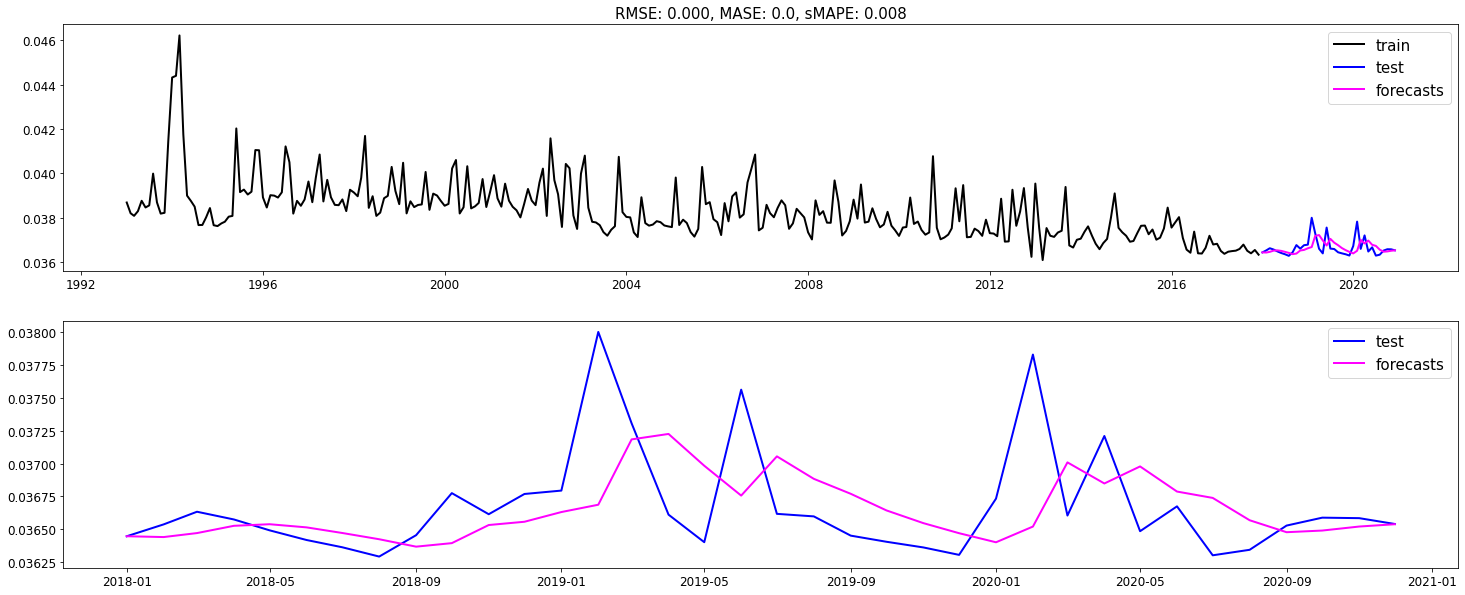

In [15]:
plot_sktime_results(train, test, scores_expanding, predictions_test, method=method, fh=fh, preprocess=preprocess,
                    linewidth = 2, axis_labelsize = 12, legend_text_size = 15)